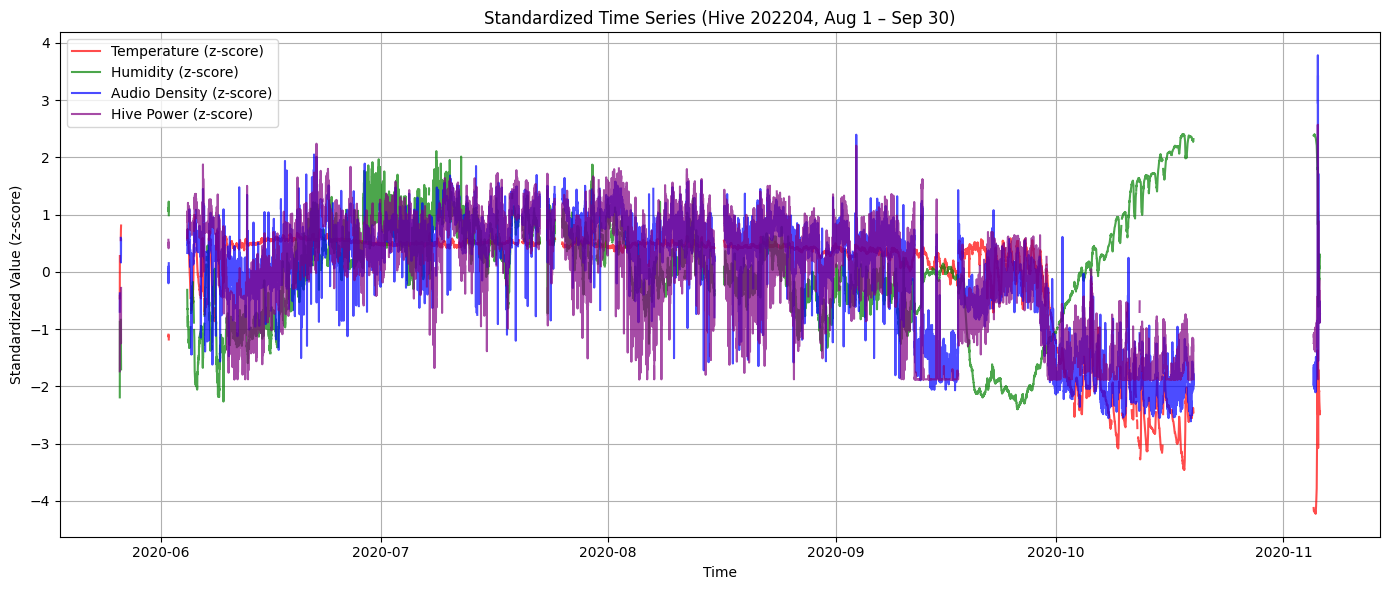

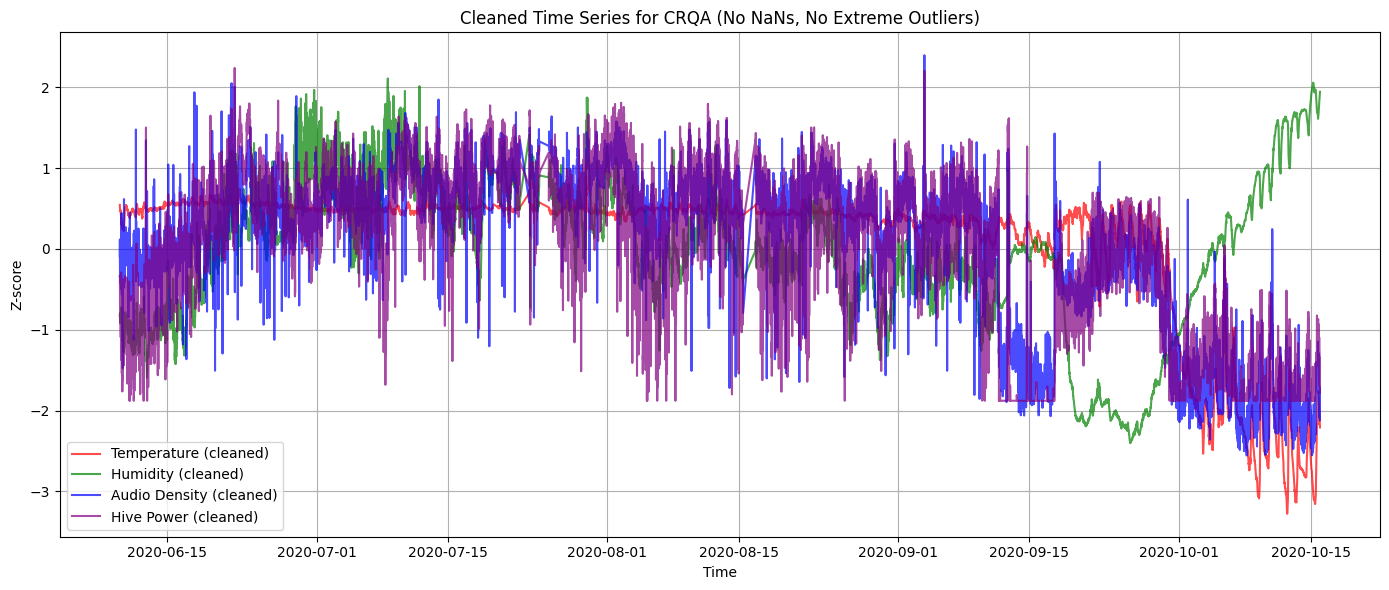

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# 1. Load data from CSV
file_path = r"C:\Users\nawat\Desktop\CS\dataset\D1_sensor_data.csv"
df = pd.read_csv(file_path, parse_dates=["published_at"])

# 2. Filter specific hive with tag_number = 202204
df = df[df["tag_number"] == 202204]

# 3. Drop duplicate timestamps
df = df.drop_duplicates(subset="published_at")

# 4. Set timestamp as index and select target columns (including humidity + hive_power)
df = df.set_index("published_at")
df = df[["temperature", "humidity", "audio_density", "hive_power"]]

# 5. Resample to align timestamps (every 15 minutes)
df_resampled = df.resample("15min").mean()

# 6. Standardize all variables
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_resampled),
    columns=["temperature_z", "humidity_z", "audio_density_z", "hive_power_z"],
    index=df_resampled.index
)

# 7. EDA Plotting
plt.figure(figsize=(14, 6))
plt.plot(df_scaled.index, df_scaled["temperature_z"], label="Temperature (z-score)", color="red", alpha=0.7)
plt.plot(df_scaled.index, df_scaled["humidity_z"], label="Humidity (z-score)", color="green", alpha=0.7)
plt.plot(df_scaled.index, df_scaled["audio_density_z"], label="Audio Density (z-score)", color="blue", alpha=0.7)
plt.plot(df_scaled.index, df_scaled["hive_power_z"], label="Hive Power (z-score)", color="purple", alpha=0.7)
plt.title("Standardized Time Series (Hive 202204, Aug 1 – Sep 30)")
plt.xlabel("Time")
plt.ylabel("Standardized Value (z-score)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7.5 Slice time range (from 2020-06-10 to 2020-10-15)
start_date = "2020-06-10"
end_date = "2020-10-15"
df_scaled = df_scaled.loc[start_date:end_date]

# 8. Drop rows with any NaNs
df_cleaned = df_scaled.dropna()

# 9. Confirm no NaNs remain
assert not df_cleaned.isnull().any().any(), "NaN values remain — not suitable for CRQA!"

# 10. Remove extreme z-score outliers (> 4)
threshold = 4
mask = (df_cleaned.abs() < threshold).all(axis=1)
df_final = df_cleaned[mask]

# 11. Confirm shapes match
assert all(df_final[col].shape == df_final["temperature_z"].shape for col in df_final.columns), "Shape mismatch"
assert (df_final.index == df_final.index).all(), "Index mismatch"

# 🔍 Plot the cleaned data
plt.figure(figsize=(14, 6))
plt.plot(df_final.index, df_final["temperature_z"], label="Temperature (cleaned)", color="red", alpha=0.7)
plt.plot(df_final.index, df_final["humidity_z"], label="Humidity (cleaned)", color="green", alpha=0.7)
plt.plot(df_final.index, df_final["audio_density_z"], label="Audio Density (cleaned)", color="blue", alpha=0.7)
plt.plot(df_final.index, df_final["hive_power_z"], label="Hive Power (cleaned)", color="purple", alpha=0.7)
plt.title("Cleaned Time Series for CRQA (No NaNs, No Extreme Outliers)")
plt.xlabel("Time")
plt.ylabel("Z-score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


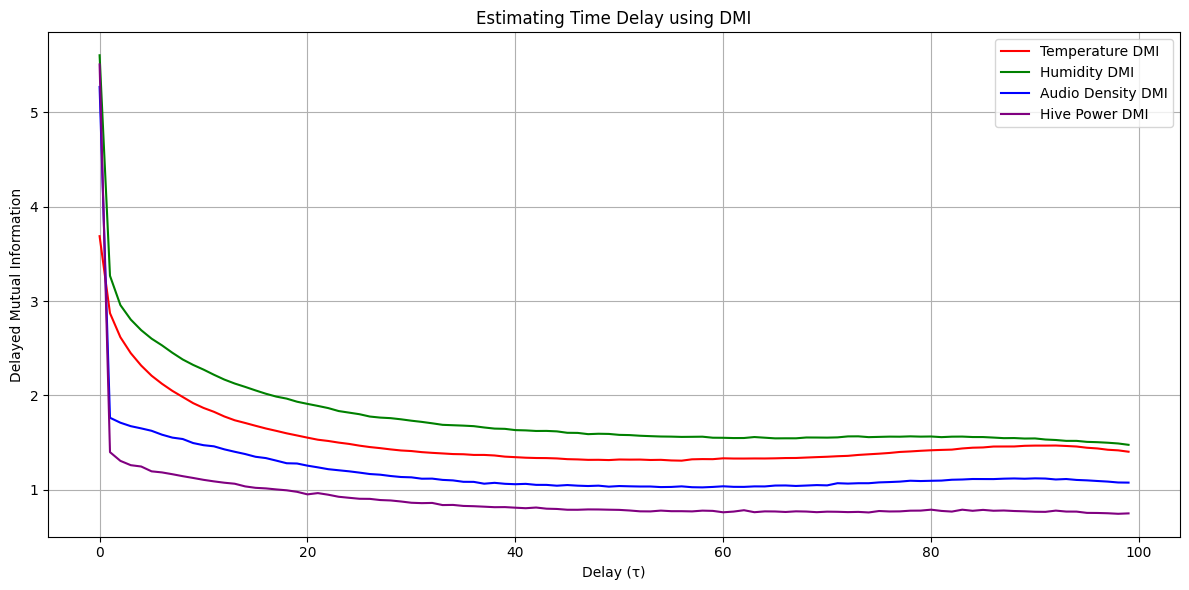

Estimated τ for temperature: 47
Estimated τ for humidity: 42
Estimated τ for audio_density: 31
Estimated τ for hive_power: 20


In [5]:
from nolitsa import delay
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import numpy as np

# 取标准化后的时间序列值
temperature = df_final['temperature_z'].values
humidity = df_final['humidity_z'].values
audio_density = df_final['audio_density_z'].values
hive_power = df_final['hive_power_z'].values

# 设置最大延迟
max_tau = 100

# 计算 DMI
dmi_temp = delay.dmi(temperature, maxtau=max_tau)
dmi_humid = delay.dmi(humidity, maxtau=max_tau)
dmi_audio = delay.dmi(audio_density, maxtau=max_tau)
dmi_power = delay.dmi(hive_power, maxtau=max_tau)

# 📊 绘制四条 DMI 曲线
plt.figure(figsize=(12, 6))
plt.plot(dmi_temp, label="Temperature DMI", color='red')
plt.plot(dmi_humid, label="Humidity DMI", color='green')
plt.plot(dmi_audio, label="Audio Density DMI", color='blue')
plt.plot(dmi_power, label="Hive Power DMI", color='purple')
plt.xlabel("Delay (τ)")
plt.ylabel("Delayed Mutual Information")
plt.title("Estimating Time Delay using DMI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 🔍 查找局部最小值
minima_temp = argrelextrema(dmi_temp, np.less)[0]
minima_humid = argrelextrema(dmi_humid, np.less)[0]
minima_audio = argrelextrema(dmi_audio, np.less)[0]
minima_power = argrelextrema(dmi_power, np.less)[0]

# 返回第一个局部最小值（如找不到则设为 10）
tau_temp = minima_temp[0] if len(minima_temp) > 0 else 10
tau_humid = minima_humid[0] if len(minima_humid) > 0 else 10
tau_audio = minima_audio[0] if len(minima_audio) > 0 else 10
tau_power = minima_power[0] if len(minima_power) > 0 else 10

# 打印所有推荐 τ
print(f"Estimated τ for temperature: {tau_temp}")
print(f"Estimated τ for humidity: {tau_humid}")
print(f"Estimated τ for audio_density: {tau_audio}")
print(f"Estimated τ for hive_power: {tau_power}")


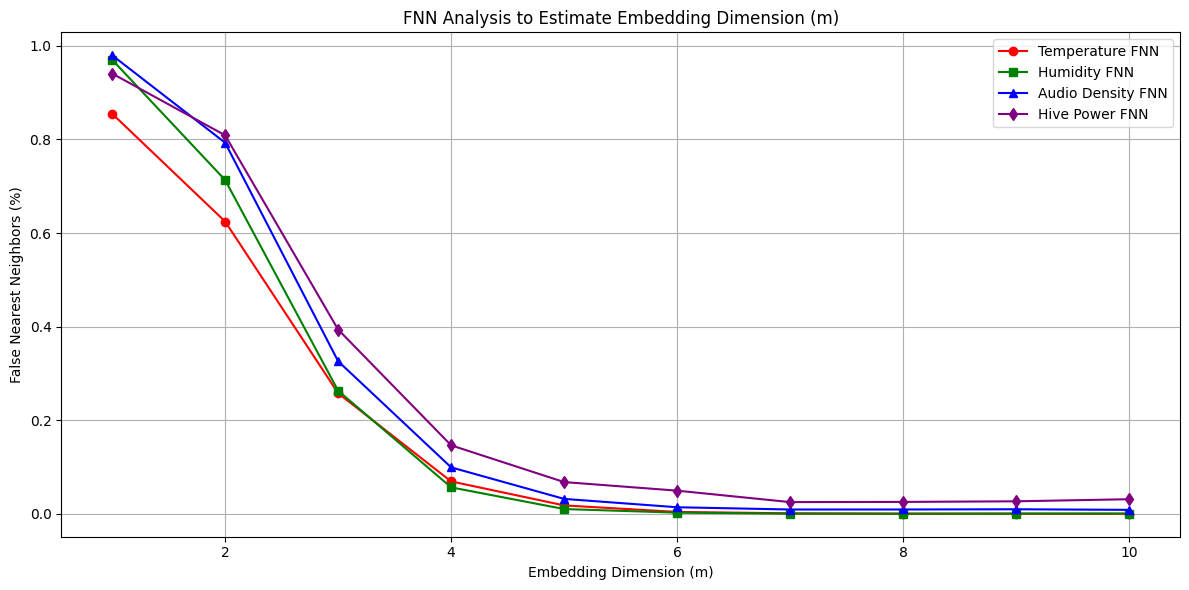

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from nolitsa import dimension

# 延迟参数（来自 DMI 分析）
tau_temp = 47
tau_audio = 31
tau_humid = 42
tau_power = 20  # ← 根据之前你得到的 hive_power 的 τ

# 嵌入维度范围
dims = np.arange(1, 11)

# 提取四个标准化后的时间序列
temperature = df_final['temperature_z'].values
humidity = df_final['humidity_z'].values
audio = df_final['audio_density_z'].values
hive_power = df_final['hive_power_z'].values

# 计算 FNN（返回 f1, f2, f3）
fnn_temp = dimension.fnn(temperature, dim=dims, tau=tau_temp,
                         metric='euclidean', window=2, maxnum=250)

fnn_humid = dimension.fnn(humidity, dim=dims, tau=tau_humid,
                          metric='euclidean', window=2, maxnum=250)

fnn_audio = dimension.fnn(audio, dim=dims, tau=tau_audio,
                          metric='euclidean', window=2, maxnum=250)

fnn_power = dimension.fnn(hive_power, dim=dims, tau=tau_power,
                          metric='euclidean', window=2, maxnum=1000)

# 📊 绘图展示四个变量的 FNN 曲线（f3：同时满足 Test I & II 的比例）
plt.figure(figsize=(12, 6))
plt.plot(dims, fnn_temp[2], 'o-', label='Temperature FNN', color='red')
plt.plot(dims, fnn_humid[2], 's-', label='Humidity FNN', color='green')
plt.plot(dims, fnn_audio[2], '^-', label='Audio Density FNN', color='blue')
plt.plot(dims, fnn_power[2], 'd-', label='Hive Power FNN', color='purple')
plt.xlabel('Embedding Dimension (m)')
plt.ylabel('False Nearest Neighbors (%)')
plt.title('FNN Analysis to Estimate Embedding Dimension (m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# 嵌入参数设置
params = {
    'temperature_z':   {'tau': 47, 'm': 6},
    'humidity_z':      {'tau': 42, 'm': 6},
    'audio_density_z': {'tau': 31, 'm': 6},
    'hive_power_z':    {'tau': 20, 'm': 7},
}


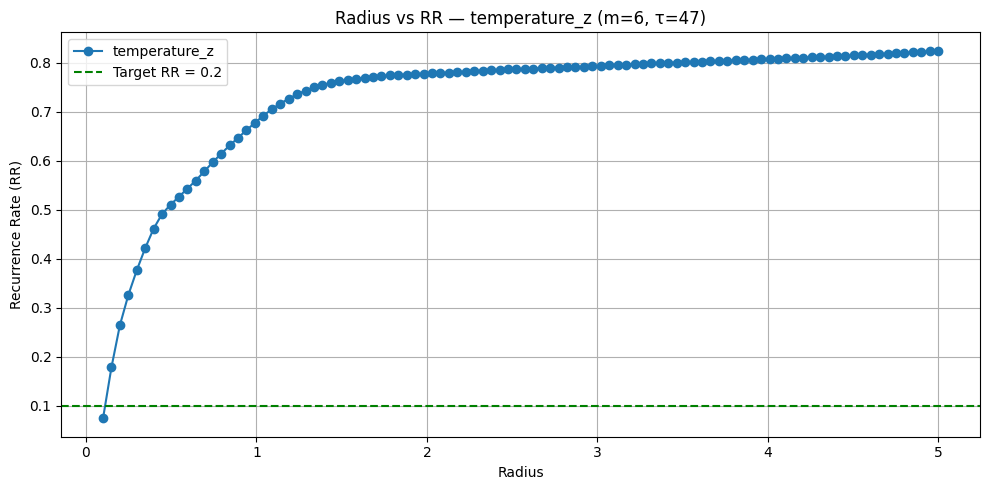

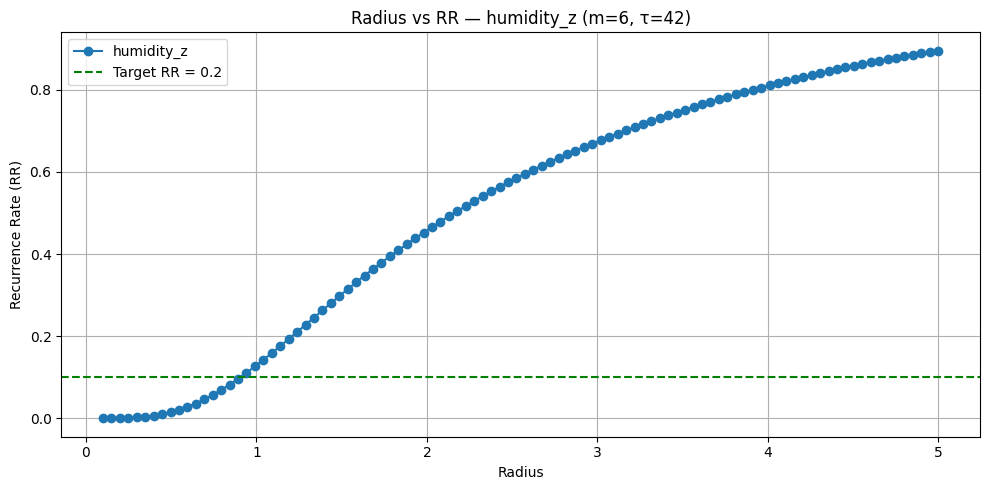

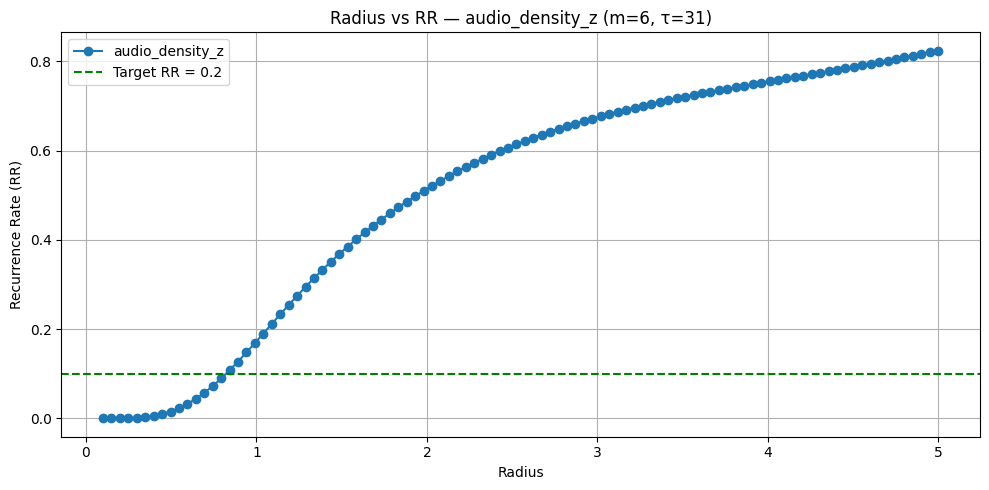

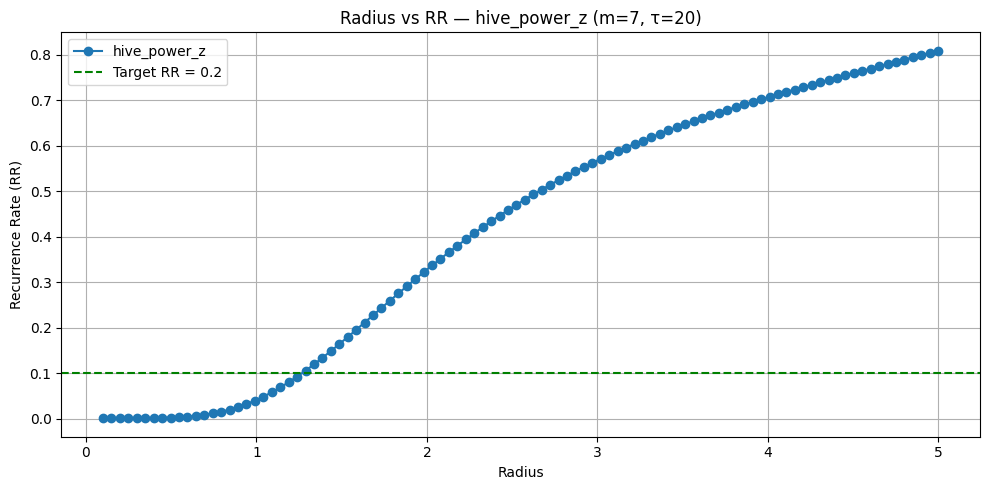

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.computation import RQAComputation
from pyrqa.neighbourhood import FixedRadius
from pyrqa.analysis_type import Classic

# ⏲ RR 计算函数
def compute_rr(time_series_data, radius_value, embedding_dimension, time_delay):
    time_series = TimeSeries(
        time_series_data.flatten(),
        embedding_dimension=embedding_dimension,
        time_delay=time_delay
    )
    settings = Settings(
        time_series,
        analysis_type=Classic,
        neighbourhood=FixedRadius(radius_value),
        theiler_corrector=1
    )
    computation = RQAComputation.create(settings)
    result = computation.run()
    return result.recurrence_rate

# 📐 各变量 τ 和 m
params = {
    'temperature_z':   {'tau': 47, 'm': 6},
    'humidity_z':      {'tau': 42, 'm': 6},
    'audio_density_z': {'tau': 31, 'm': 6},
    'hive_power_z':    {'tau': 20, 'm': 7},
}

# 🎯 目标 Recurrence Rate
target_rr = 0.10

# 🔍 半径搜索范围
radii = np.linspace(0.1, 5.0, 100)

# 🧪 主循环
for var_name, p in params.items():
    ts_data = df_final[var_name].values
    rr_values = []

    for r in radii:
        try:
            rr = compute_rr(ts_data, r, embedding_dimension=p['m'], time_delay=p['tau'])
        except Exception as e:
            rr = np.nan
        rr_values.append(rr)

    # 可视化
    plt.figure(figsize=(10, 5))
    plt.plot(radii, rr_values, marker='o', label=f'{var_name}')
    plt.axhline(y=target_rr, color='green', linestyle='--', label='Target RR = 0.2')
    plt.xlabel('Radius')
    plt.ylabel('Recurrence Rate (RR)')
    plt.title(f'Radius vs RR — {var_name} (m={p["m"]}, τ={p["tau"]})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [12]:
from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.analysis_type import Classic
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation

# 嵌入参数 + radius 配置
params = {
    'temperature_z':   {'tau': 47, 'm': 6, 'r': 0.15},
    'humidity_z':      {'tau': 42, 'm': 6, 'r': 0.9},
    'audio_density_z': {'tau': 31, 'm': 6, 'r': 0.8},
    'hive_power_z':    {'tau': 20, 'm': 7, 'r': 1.3},
}

# 循环计算每个变量的 RQA 指标
for var_name, p in params.items():
    data_points = df_final[var_name].values

    # 构造时间序列
    time_series = TimeSeries(
        data_points,
        embedding_dimension=p['m'],
        time_delay=p['tau']
    )

    # 设置 RQA 参数
    settings = Settings(
        time_series,
        analysis_type=Classic,
        neighbourhood=FixedRadius(p['r']),
        similarity_measure=EuclideanMetric,
        theiler_corrector=1
    )

    # 创建并运行计算
    computation = RQAComputation.create(settings, verbose=True)
    result = computation.run()

    # 设置最小线长度参数（可选）
    result.min_diagonal_line_length = 2
    result.min_vertical_line_length = 2
    result.min_white_vertical_line_length = 2

    # 打印结果
    print(f'\n===== RQA Results for {var_name} =====')
    print(result)


[Platform 'NVIDIA CUDA']
Vendor: NVIDIA Corporation
Version: OpenCL 3.0 CUDA 12.6.73
Profile: FULL_PROFILE
Extensions: cl_khr_global_int32_base_atomics cl_khr_global_int32_extended_atomics cl_khr_local_int32_base_atomics cl_khr_local_int32_extended_atomics cl_khr_fp64 cl_khr_3d_image_writes cl_khr_byte_addressable_store cl_khr_icd cl_khr_gl_sharing cl_nv_compiler_options cl_nv_device_attribute_query cl_nv_pragma_unroll cl_nv_d3d10_sharing cl_khr_d3d10_sharing cl_nv_d3d11_sharing cl_nv_copy_opts cl_nv_create_buffer cl_khr_int64_base_atomics cl_khr_int64_extended_atomics cl_khr_device_uuid cl_khr_pci_bus_info cl_khr_external_semaphore cl_khr_external_memory cl_khr_external_semaphore_win32 cl_khr_external_memory_win32


[Device 'NVIDIA GeForce RTX 4060 Laptop GPU']
Vendor: NVIDIA Corporation
Type: 4
Version: OpenCL 3.0 CUDA
Profile: FULL_PROFILE
Max Clock Frequency: 1890
Global Mem Size: 8585216000
Address Bits: 64
Max Compute Units: 24
Max Work Group Size: 1024
Max Work Item Dimensions: 

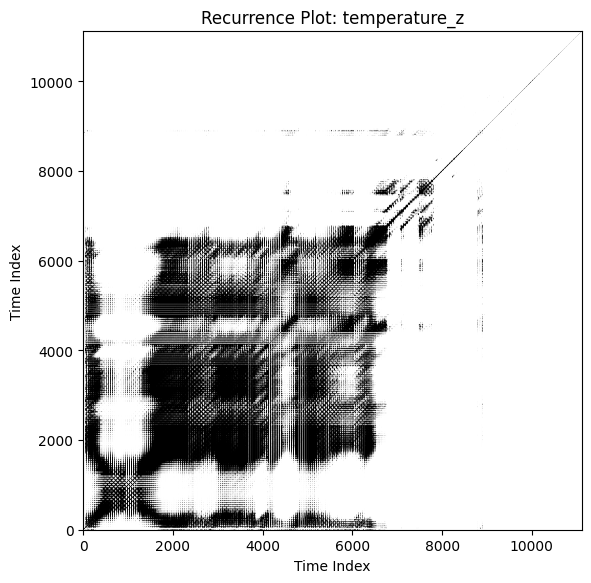

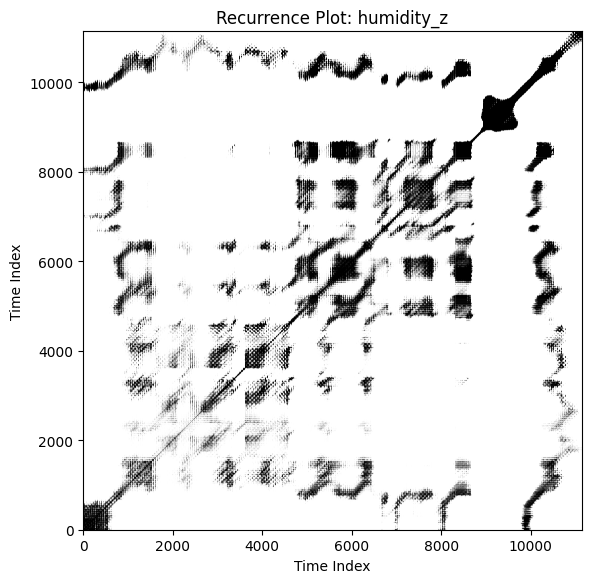

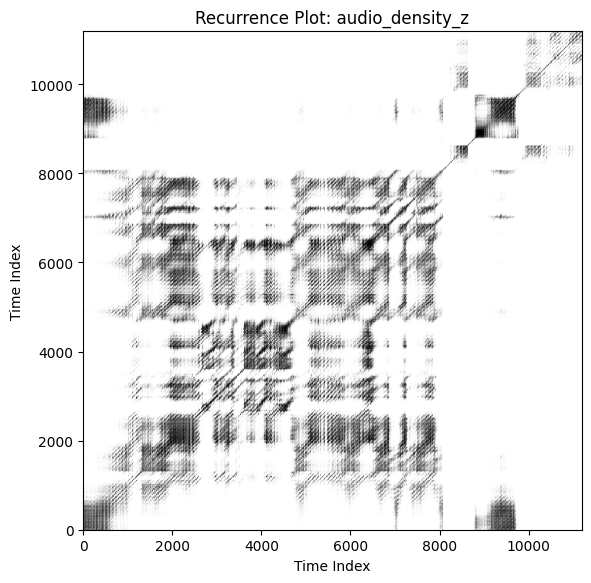

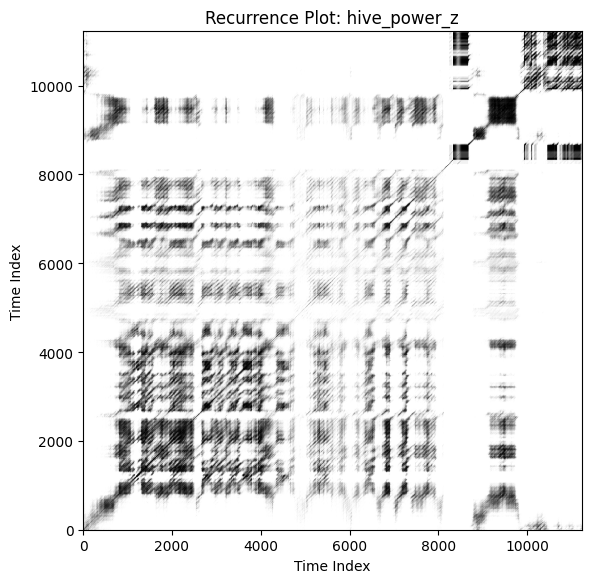

In [13]:
# RR plots without detrending — kept for comparison purposes
# DO NOT run this block or the results will be overwritten


# 配置参数
params = {
    'temperature_z':   {'tau': 47, 'm': 6, 'r': 0.15},
    'humidity_z':      {'tau': 42, 'm': 6, 'r': 0.9},
    'audio_density_z': {'tau': 31, 'm': 6, 'r': 0.8},
    'hive_power_z':    {'tau': 20, 'm': 7, 'r': 1.3},
}

# 循环绘制 Recurrence Plot
for var_name, p in params.items():
    series = df_final[var_name].values

    # 构造时间序列
    time_series = TimeSeries(
        series,
        embedding_dimension=p['m'],
        time_delay=p['tau']
    )

    # 设置
    settings = Settings(
        time_series,
        analysis_type=Classic,
        neighbourhood=FixedRadius(p['r']),
        similarity_measure=EuclideanMetric,
        theiler_corrector=1
    )

    # 创建 RP 计算器并运行
    computation = RPComputation.create(settings)
    result = computation.run()

    # 获取 Recurrence Matrix（布尔矩阵）
    rp_matrix = np.array(result.recurrence_matrix)

    # 可视化 Recurrence Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(rp_matrix, cmap='binary', origin='lower')
    plt.title(f'Recurrence Plot: {var_name}')
    plt.xlabel('Time Index')
    plt.ylabel('Time Index')
    plt.grid(False)
    plt.tight_layout()
    plt.show()


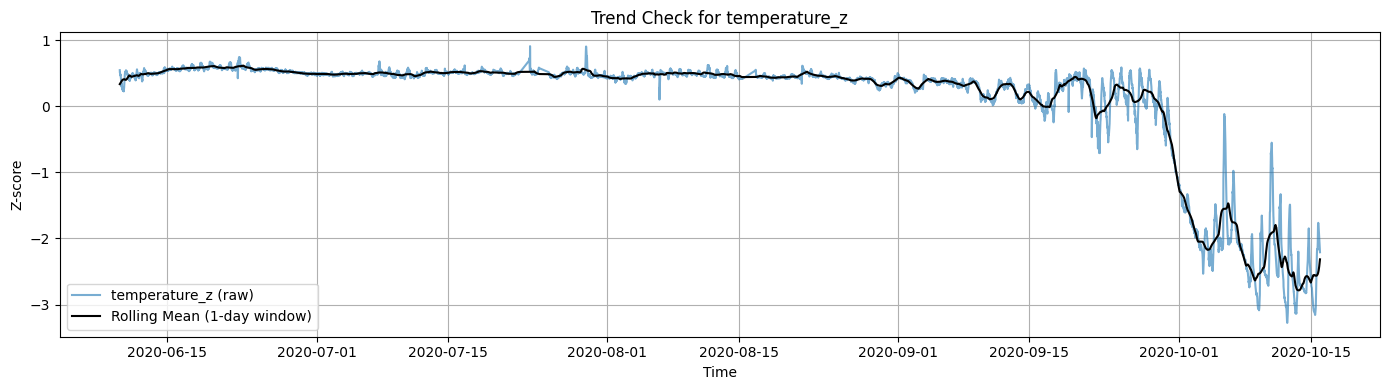

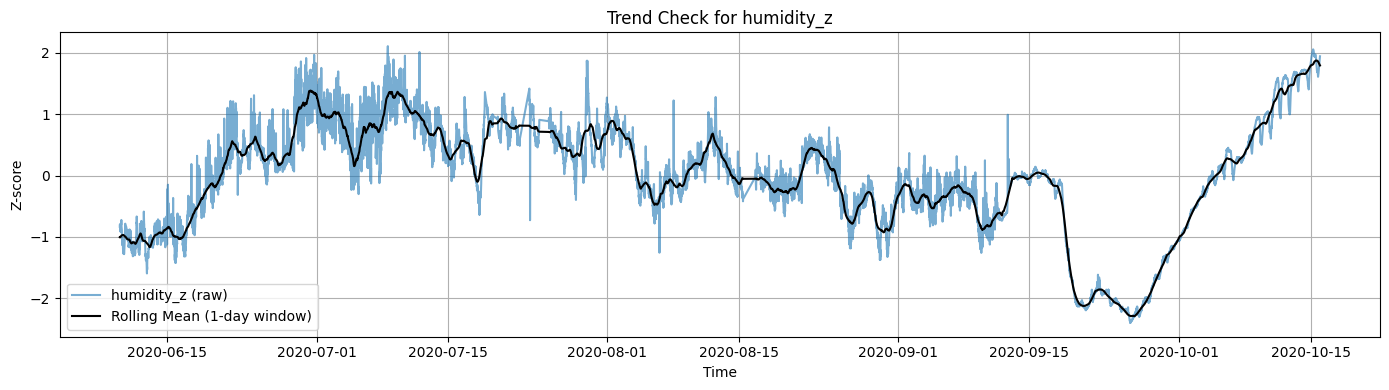

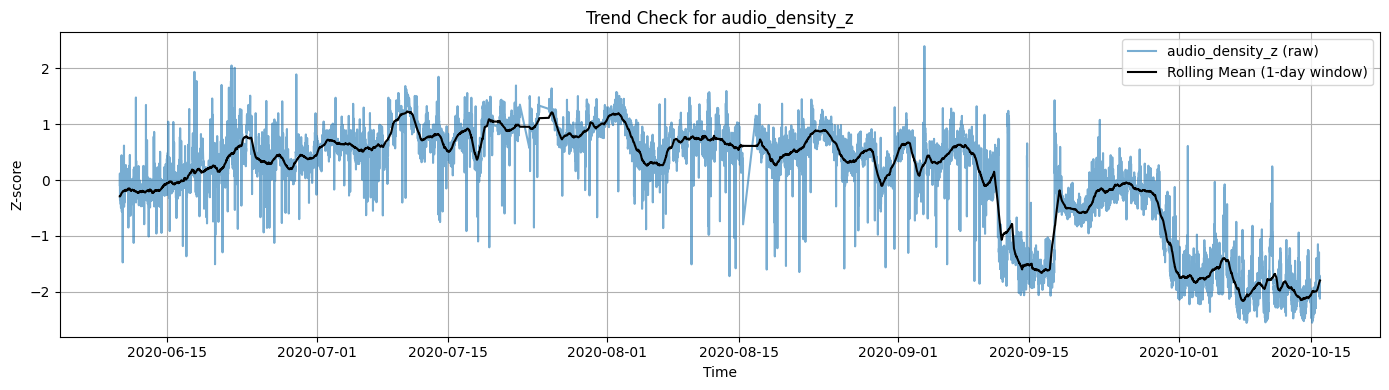

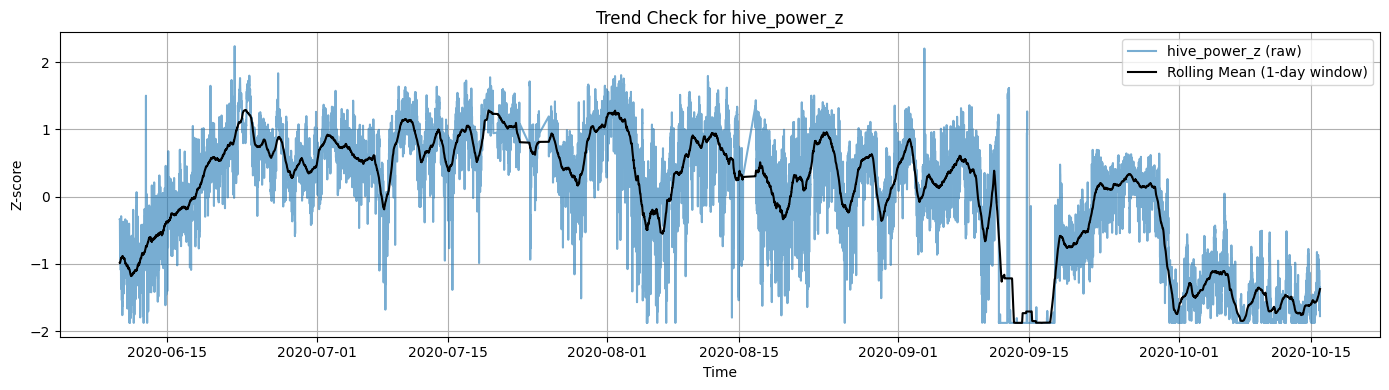

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# 设置滑动窗口（每15分钟采样，96步 = 1天）
window_size = 96

# 遍历每个变量
for col in df_final.columns:
    series = df_final[col]
    rolling_mean = series.rolling(window=window_size, center=True, min_periods=1).mean()

    plt.figure(figsize=(14, 4))
    plt.plot(series.index, series, label=f'{col} (raw)', alpha=0.6)
    plt.plot(series.index, rolling_mean, label='Rolling Mean (1-day window)', color='black')
    plt.title(f'Trend Check for {col}')
    plt.xlabel('Time')
    plt.ylabel('Z-score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


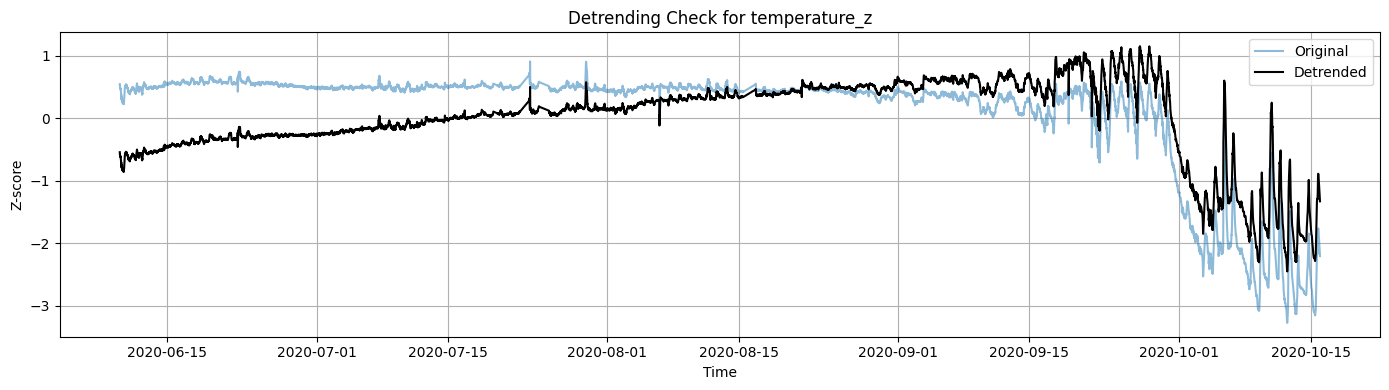

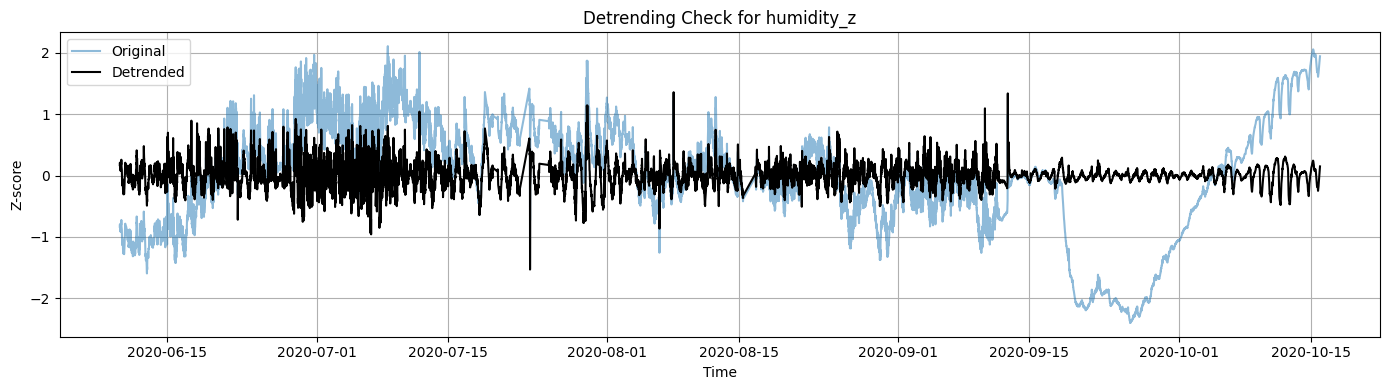

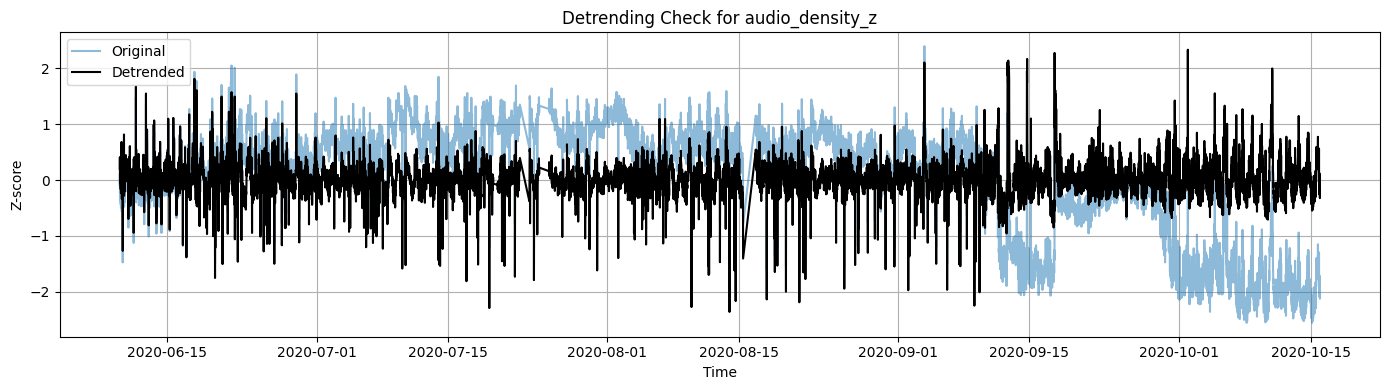

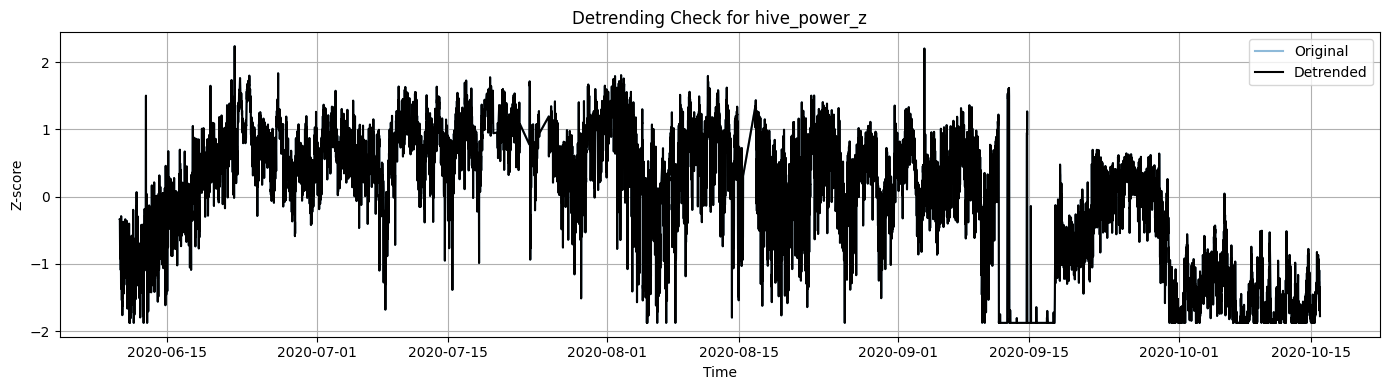

In [15]:
from scipy.signal import detrend

# 创建一个新的 DataFrame 用于存放去趋势后的结果
df_detrended = df_final.copy()

# 温度：使用线性去趋势
df_detrended['temperature_z'] = detrend(df_final['temperature_z'].values, type='linear')

# 湿度：用滑动均值去趋势（96步 = 1天）
window_size = 96
humidity_trend = df_final['humidity_z'].rolling(window=window_size, center=True, min_periods=1).mean()
df_detrended['humidity_z'] = df_final['humidity_z'] - humidity_trend

# 音频密度：用滑动均值去趋势（96步 = 1天）
audio_trend = df_final['audio_density_z'].rolling(window=window_size, center=True, min_periods=1).mean()
df_detrended['audio_density_z'] = df_final['audio_density_z'] - audio_trend

# 蜂群功率不做处理，保留原值
# df_detrended['hive_power_z'] = df_final['hive_power_z']（已经是）

# 可选：绘图检查一下去趋势后的效果
import matplotlib.pyplot as plt

for col in df_detrended.columns:
    plt.figure(figsize=(14, 4))
    plt.plot(df_final.index, df_final[col], label='Original', alpha=0.5)
    plt.plot(df_detrended.index, df_detrended[col], label='Detrended', color='black')
    plt.title(f'Detrending Check for {col}')
    plt.xlabel('Time')
    plt.ylabel('Z-score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


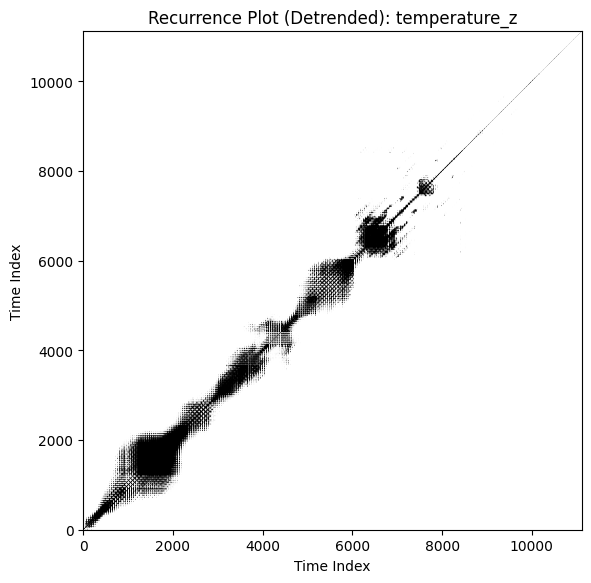

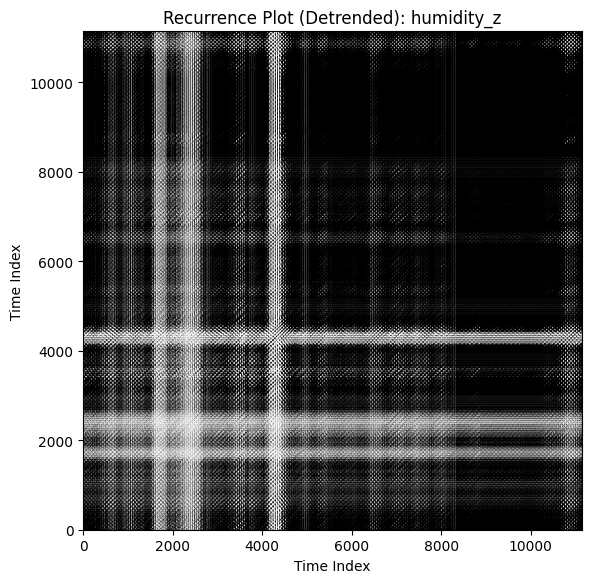

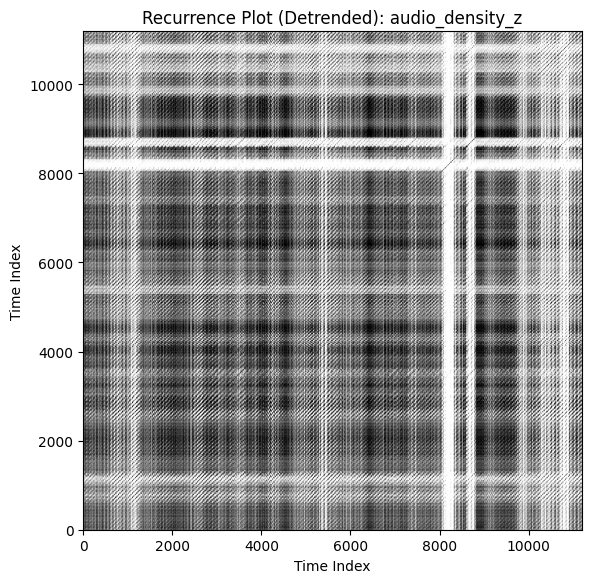

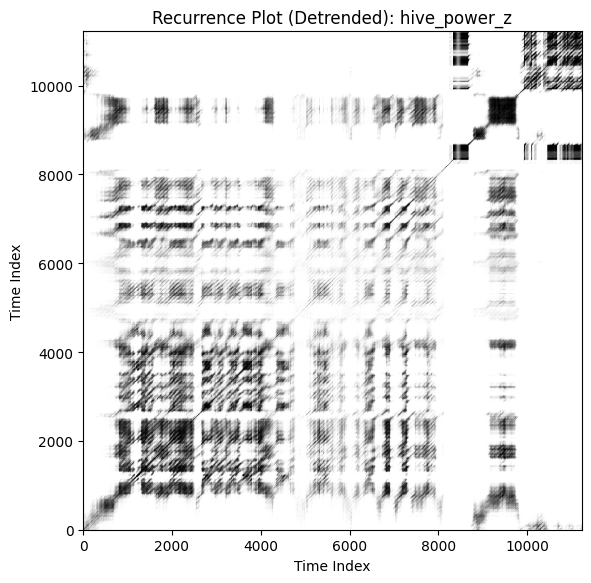

In [16]:
import matplotlib.pyplot as plt
from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.analysis_type import Classic
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RPComputation
import numpy as np

# 嵌入参数配置
params = {
    'temperature_z':   {'tau': 47, 'm': 6, 'r': 0.15},
    'humidity_z':      {'tau': 42, 'm': 6, 'r': 0.9},
    'audio_density_z': {'tau': 31, 'm': 6, 'r': 0.8},
    'hive_power_z':    {'tau': 20, 'm': 7, 'r': 1.3},
}

# 使用 df_detrended 数据
for var_name, p in params.items():
    series = df_detrended[var_name].values  # <-- 使用去趋势后的数据

    # 构造时间序列
    time_series = TimeSeries(
        series,
        embedding_dimension=p['m'],
        time_delay=p['tau']
    )

    # 设置参数
    settings = Settings(
        time_series,
        analysis_type=Classic,
        neighbourhood=FixedRadius(p['r']),
        similarity_measure=EuclideanMetric,
        theiler_corrector=1
    )

    # 创建 Recurrence Plot 计算器
    computation = RPComputation.create(settings)
    result = computation.run()

    # 取得 Recurrence Matrix
    rp_matrix = np.array(result.recurrence_matrix)

    # 绘图
    plt.figure(figsize=(6, 6))
    plt.imshow(rp_matrix, cmap='binary', origin='lower')
    plt.title(f'Recurrence Plot (Detrended): {var_name}')
    plt.xlabel('Time Index')
    plt.ylabel('Time Index')
    plt.grid(False)
    plt.tight_layout()
    plt.show()


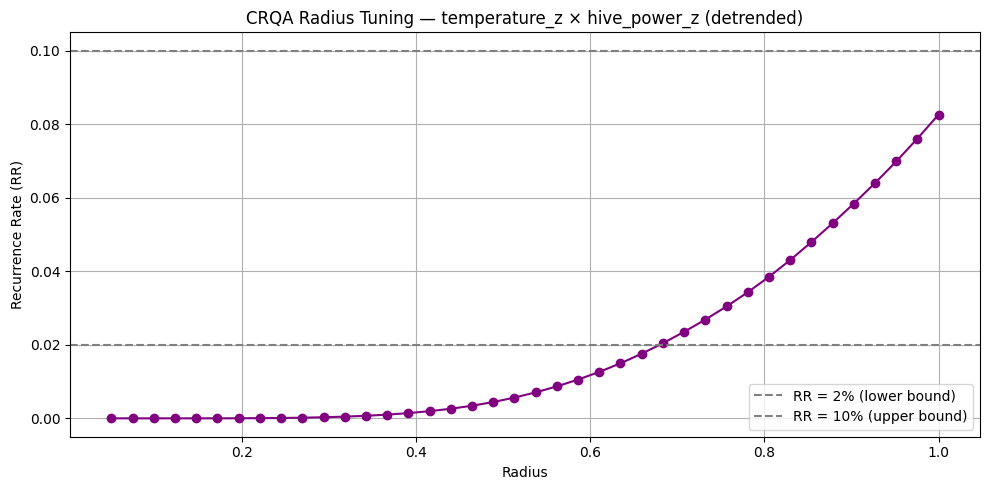

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.analysis_type import Cross
from pyrqa.metric import EuclideanMetric
from pyrqa.neighbourhood import FixedRadius
from pyrqa.computation import RQAComputation

# ✅ 使用去趋势化后的数据
temperature = df_detrended['temperature_z'].values
hive_power = df_detrended['hive_power_z'].values

# ✅ 设置嵌入参数（对称）
embedding_dim = 7
tau = 33

# ✅ 构建 TimeSeries 对象（对称 embedding）
ts_temp = TimeSeries(temperature, embedding_dimension=embedding_dim, time_delay=tau)
ts_power = TimeSeries(hive_power, embedding_dimension=embedding_dim, time_delay=tau)

# ✅ 半径搜索范围（共 40 个值）
radius_list = np.linspace(0.05, 1.0, 40)
rr_list = []

# ✅ 遍历每个半径计算 CRQA 的 RR
for r in radius_list:
    settings = Settings((ts_temp, ts_power),
                        analysis_type=Cross,
                        neighbourhood=FixedRadius(r),
                        similarity_measure=EuclideanMetric,
                        theiler_corrector=1)
    computation = RQAComputation.create(settings)
    result = computation.run()
    rr_list.append(result.recurrence_rate)

# ✅ 绘制 Radius vs RR 曲线图
plt.figure(figsize=(10, 5))
plt.plot(radius_list, rr_list, 'o-', color='purple')
plt.axhline(0.02, color='gray', linestyle='--', label='RR = 2% (lower bound)')
plt.axhline(0.10, color='gray', linestyle='--', label='RR = 10% (upper bound)')
plt.xlabel("Radius")
plt.ylabel("Recurrence Rate (RR)")
plt.title("CRQA Radius Tuning — temperature_z × hive_power_z (detrended)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[Platform 'NVIDIA CUDA']
Vendor: NVIDIA Corporation
Version: OpenCL 3.0 CUDA 12.6.73
Profile: FULL_PROFILE
Extensions: cl_khr_global_int32_base_atomics cl_khr_global_int32_extended_atomics cl_khr_local_int32_base_atomics cl_khr_local_int32_extended_atomics cl_khr_fp64 cl_khr_3d_image_writes cl_khr_byte_addressable_store cl_khr_icd cl_khr_gl_sharing cl_nv_compiler_options cl_nv_device_attribute_query cl_nv_pragma_unroll cl_nv_d3d10_sharing cl_khr_d3d10_sharing cl_nv_d3d11_sharing cl_nv_copy_opts cl_nv_create_buffer cl_khr_int64_base_atomics cl_khr_int64_extended_atomics cl_khr_device_uuid cl_khr_pci_bus_info cl_khr_external_semaphore cl_khr_external_memory cl_khr_external_semaphore_win32 cl_khr_external_memory_win32


[Device 'NVIDIA GeForce RTX 4060 Laptop GPU']
Vendor: NVIDIA Corporation
Type: 4
Version: OpenCL 3.0 CUDA
Profile: FULL_PROFILE
Max Clock Frequency: 1890
Global Mem Size: 8585216000
Address Bits: 64
Max Compute Units: 24
Max Work Group Size: 1024
Max Work Item Dimensions: 

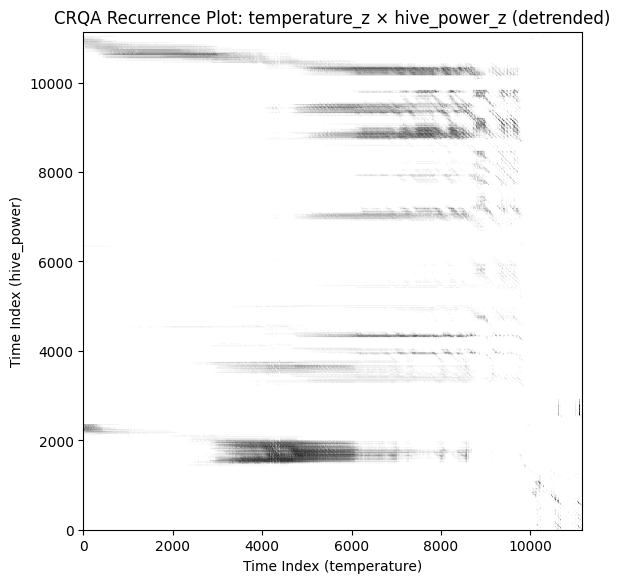

In [21]:
from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.analysis_type import Cross
from pyrqa.metric import EuclideanMetric
from pyrqa.neighbourhood import FixedRadius
from pyrqa.computation import RQAComputation, RPComputation
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Time series from detrended data
# 假设你已经定义：
# temperature = df_detrended['temperature_z'].values
# hive_power = df_detrended['hive_power_z'].values

# Step 2: Create TimeSeries objects (embedding_dimension=7, time_delay=33)
time_series_temp = TimeSeries(temperature,
                              embedding_dimension=7,
                              time_delay=33)

time_series_power = TimeSeries(hive_power,
                               embedding_dimension=7,
                               time_delay=33)

# Step 3: CRQA Settings
settings = Settings((time_series_temp, time_series_power),
                    analysis_type=Cross,
                    neighbourhood=FixedRadius(0.7),
                    similarity_measure=EuclideanMetric,
                    theiler_corrector=1)

# Step 4: Run CRQA computation
computation = RQAComputation.create(settings, verbose=True)
result = computation.run()

# Optional line length cutoffs
result.min_diagonal_line_length = 2
result.min_vertical_line_length = 2
result.min_white_vertical_line_length = 2

# Step 5: Print results
print(result)

# Step 6: Compute Recurrence Plot (not just RQA)
rp_computation = RPComputation.create(settings)
rp_result = rp_computation.run()

# Step 7: Display the recurrence plot
rp_matrix = np.array(rp_result.recurrence_matrix_reverse)

plt.figure(figsize=(6, 6))
plt.imshow(rp_matrix, cmap='binary', origin='lower')
plt.title('CRQA Recurrence Plot: temperature_z × hive_power_z (detrended)')
plt.xlabel('Time Index (temperature)')
plt.ylabel('Time Index (hive_power)')
plt.tight_layout()
plt.show()


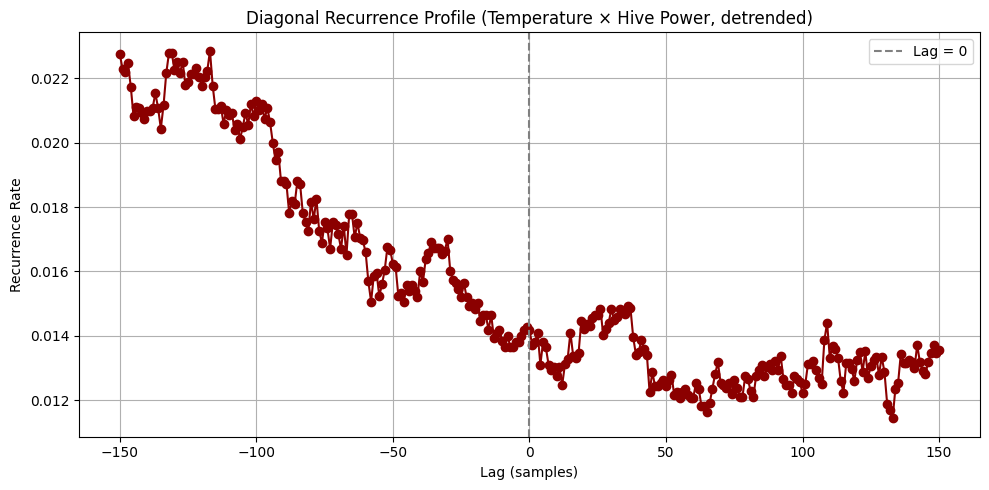

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.analysis_type import Cross
from pyrqa.metric import EuclideanMetric
from pyrqa.neighbourhood import FixedRadius
from pyrqa.computation import RPComputation

# 使用去趋势后的数据
# temperature = df_detrended['temperature_z'].values
# hive_power = df_detrended['hive_power_z'].values

# Step 1: Construct TimeSeries with asymmetric CRQA embedding
ts_temp = TimeSeries(temperature, embedding_dimension=7, time_delay=33)
ts_power = TimeSeries(hive_power, embedding_dimension=7, time_delay=33)

# Step 2: CRQA settings
settings = Settings((ts_temp, ts_power),
                    analysis_type=Cross,
                    neighbourhood=FixedRadius(0.7),
                    similarity_measure=EuclideanMetric,
                    theiler_corrector=1)

# Step 3: Compute recurrence matrix
computation = RPComputation.create(settings)
result = computation.run()
rec_matrix = result.recurrence_matrix_reverse.astype(int)

# Step 4: Compute DRP
def compute_drp(matrix, max_lag=150):
    size = matrix.shape[0]
    lags = np.arange(-max_lag, max_lag + 1)
    rr_lag = []
    for lag in lags:
        diag = np.diag(matrix, k=lag)
        rr = np.sum(diag) / len(diag) if len(diag) > 0 else 0
        rr_lag.append(rr)
    return lags, rr_lag

lags, rr_values = compute_drp(rec_matrix, max_lag=150)

# Step 5: Plot DRP
plt.figure(figsize=(10, 5))
plt.plot(lags, rr_values, marker='o', linestyle='-', color='darkred')
plt.axvline(0, color='gray', linestyle='--', label='Lag = 0')
plt.title("Diagonal Recurrence Profile (Temperature × Hive Power, detrended)")
plt.xlabel("Lag (samples)")
plt.ylabel("Recurrence Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


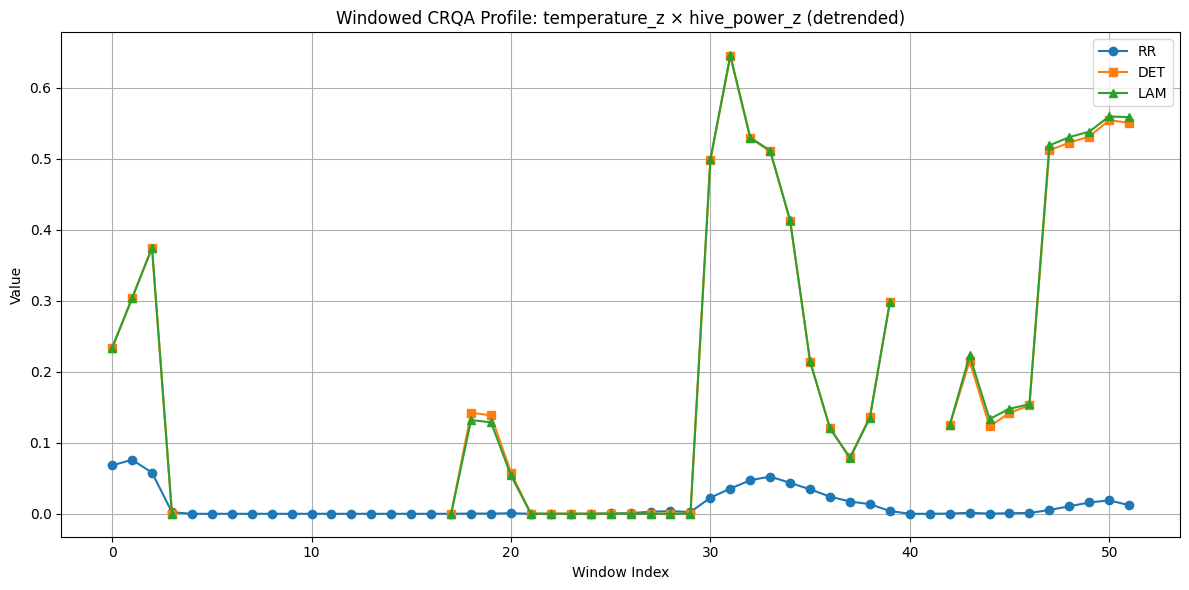

In [30]:
from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.analysis_type import Cross
from pyrqa.metric import EuclideanMetric
from pyrqa.neighbourhood import FixedRadius
from pyrqa.computation import RQAComputation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set parameters
window_size = 1000    # 每个窗口长度（样本点数）
window_step = 200     # 每步滑动量
embedding_dim = 7     # 嵌入维度
tau = 33              # 延迟时间
radius = 0.7          # Recurrence 半径

# Load detrended time series
ts1 = df_detrended['temperature_z'].values
ts2 = df_detrended['hive_power_z'].values

# Calculate number of windows
n_windows = (len(ts1) - window_size) // window_step + 1

# Containers for results
rr_list = []
det_list = []
lam_list = []

for i in range(n_windows):
    start = i * window_step
    end = start + window_size

    segment1 = ts1[start:end]
    segment2 = ts2[start:end]

    ts_obj1 = TimeSeries(segment1, embedding_dimension=embedding_dim, time_delay=tau)
    ts_obj2 = TimeSeries(segment2, embedding_dimension=embedding_dim, time_delay=tau)

    settings = Settings((ts_obj1, ts_obj2),
                        analysis_type=Cross,
                        neighbourhood=FixedRadius(radius),
                        similarity_measure=EuclideanMetric,
                        theiler_corrector=1)

    computation = RQAComputation.create(settings)
    result = computation.run()

    rr_list.append(result.recurrence_rate)
    det_list.append(result.determinism)
    lam_list.append(result.laminarity)

# Convert to DataFrame
results_df = pd.DataFrame({
    'window': np.arange(n_windows),
    'RR': rr_list,
    'DET': det_list,
    'LAM': lam_list
})

# Plot Windowed CRQA Profiles
plt.figure(figsize=(12, 6))
plt.plot(results_df['window'], results_df['RR'], label='RR', marker='o')
plt.plot(results_df['window'], results_df['DET'], label='DET', marker='s')
plt.plot(results_df['window'], results_df['LAM'], label='LAM', marker='^')
plt.xlabel('Window Index')
plt.ylabel('Value')
plt.title('Windowed CRQA Profile: temperature_z × hive_power_z (detrended)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


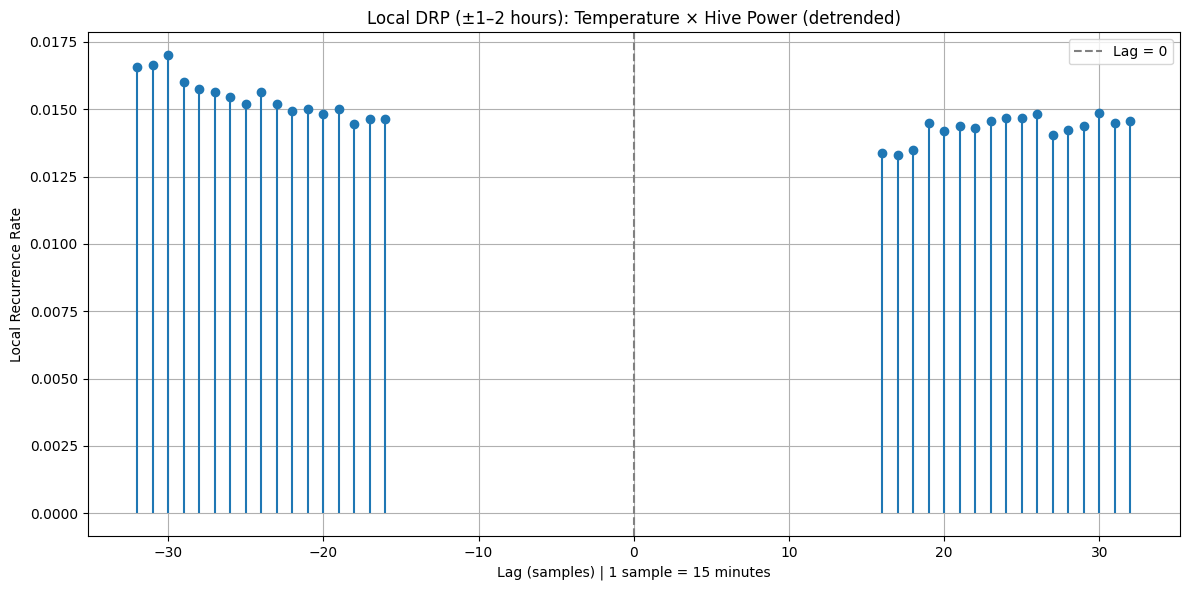

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.analysis_type import Cross
from pyrqa.metric import EuclideanMetric
from pyrqa.neighbourhood import FixedRadius
from pyrqa.computation import RPComputation

# 使用去趋势化后的变量
temperature = df_detrended['temperature_z'].values
hive_power = df_detrended['hive_power_z'].values

# 嵌入参数
embedding_dim = 7
tau = 33
radius = 0.7

# 创建 TimeSeries 对象
ts_temp = TimeSeries(temperature, embedding_dimension=embedding_dim, time_delay=tau)
ts_power = TimeSeries(hive_power, embedding_dimension=embedding_dim, time_delay=tau)

# 设置 CRQA 配置
settings = Settings((ts_temp, ts_power),
                    analysis_type=Cross,
                    neighbourhood=FixedRadius(radius),
                    similarity_measure=EuclideanMetric,
                    theiler_corrector=1)

# 计算 Recurrence Matrix
computation = RPComputation.create(settings)
result = computation.run()
rec_matrix = result.recurrence_matrix_reverse.astype(int)

# 🔍 计算 ±1~2 小时范围内的 RR（滞后 4-8，即每步 15 分钟）
def local_drp(matrix, min_lag=4, max_lag=8):
    rr_list = []
    lags = []
    for lag in range(min_lag, max_lag + 1):
        for signed_lag in [-lag, lag]:
            diag = np.diag(matrix, k=signed_lag)
            if len(diag) > 0:
                rr = np.sum(diag) / len(diag)
                rr_list.append(rr)
                lags.append(signed_lag)
    return lags, rr_list

# 执行计算
lags, rr_values = local_drp(rec_matrix, min_lag=16, max_lag=32)

# 可视化结果
plt.figure(figsize=(12, 6))
plt.stem(lags, rr_values, basefmt=" ")  # 删除了 use_line_collection
plt.axvline(0, color='gray', linestyle='--', label='Lag = 0')
plt.xlabel('Lag (samples) | 1 sample = 15 minutes')
plt.ylabel('Local Recurrence Rate')
plt.title('Local DRP (±1–2 hours): Temperature × Hive Power (detrended)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



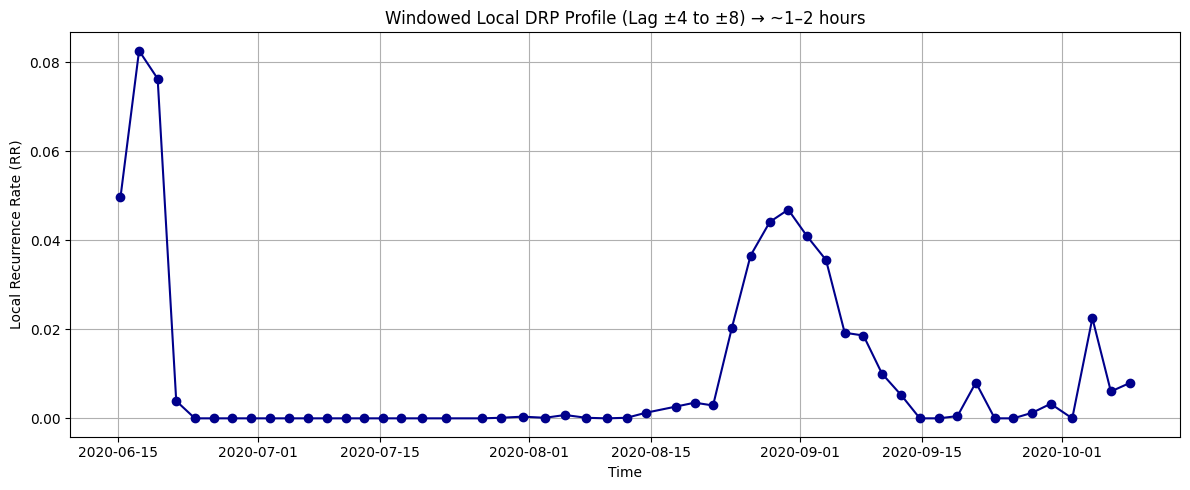

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.analysis_type import Cross
from pyrqa.metric import EuclideanMetric
from pyrqa.neighbourhood import FixedRadius
from pyrqa.computation import RPComputation

# 使用去趋势化后的变量
ts1 = df_detrended['temperature_z'].values
ts2 = df_detrended['hive_power_z'].values
timestamps = df_detrended.index

# 参数设置
embedding_dim = 7
tau = 33
radius = 0.7

window_size = 1000       # 每个窗口 1000 点 ≈ 10.4 天
window_step = 200        # 每次移动 200 点 ≈ 2 天
lag_min = 4              # 滞后4点 = 1小时
lag_max = 8              # 滞后8点 = 2小时

def compute_local_rr(matrix, lag_min, lag_max):
    total_rr = 0
    count = 0
    for lag in range(lag_min, lag_max + 1):
        for sign in [-1, 1]:
            diag = np.diag(matrix, k=lag * sign)
            if len(diag) > 0:
                rr = np.sum(diag) / len(diag)
                total_rr += rr
                count += 1
    return total_rr / count if count > 0 else 0

# 滑动窗口分析
n_windows = (len(ts1) - window_size) // window_step + 1
local_rrs = []
time_labels = []

for i in range(n_windows):
    start = i * window_step
    end = start + window_size

    seg1 = ts1[start:end]
    seg2 = ts2[start:end]
    seg_time = timestamps[start + window_size // 2]  # 时间标签取中点

    ts_obj1 = TimeSeries(seg1, embedding_dimension=embedding_dim, time_delay=tau)
    ts_obj2 = TimeSeries(seg2, embedding_dimension=embedding_dim, time_delay=tau)

    settings = Settings((ts_obj1, ts_obj2),
                        analysis_type=Cross,
                        neighbourhood=FixedRadius(radius),
                        similarity_measure=EuclideanMetric,
                        theiler_corrector=1)

    computation = RPComputation.create(settings)
    result = computation.run()
    matrix = result.recurrence_matrix_reverse.astype(int)

    rr_local = compute_local_rr(matrix, lag_min, lag_max)
    local_rrs.append(rr_local)
    time_labels.append(seg_time)

# 可视化
plt.figure(figsize=(12, 5))
plt.plot(time_labels, local_rrs, marker='o', color='darkblue')
plt.title("Windowed Local DRP Profile (Lag ±4 to ±8) → ~1–2 hours")
plt.xlabel("Time")
plt.ylabel("Local Recurrence Rate (RR)")
plt.grid(True)
plt.tight_layout()
plt.show()


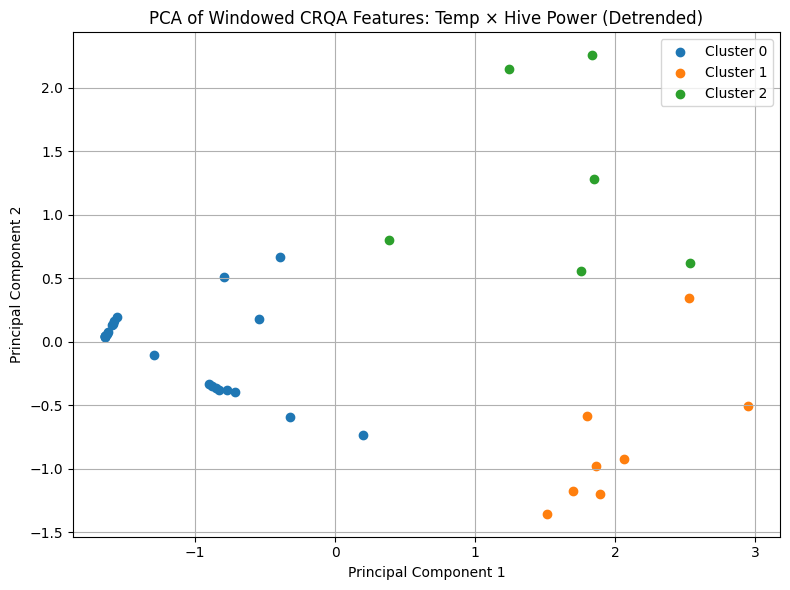

In [33]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# 假设你前面 windowed CRQA 的结果叫 results_df
# 并且是 temperature_z × hive_power_z（detrended）对应的滑窗结果

# 1️⃣ 移除含 NaN 的窗口行
results_df_clean = results_df.dropna(subset=['RR', 'DET', 'LAM']).copy()

# 2️⃣ 提取特征并标准化
features = ['RR', 'DET', 'LAM']
X = results_df_clean[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3️⃣ PCA 降维（两维）
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 4️⃣ 聚类分析（可调整 n_clusters）
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# 5️⃣ 将聚类结果与主成分加入 DataFrame
results_df_clean['PC1'] = X_pca[:, 0]
results_df_clean['PC2'] = X_pca[:, 1]
results_df_clean['cluster'] = clusters

# 6️⃣ 可视化
plt.figure(figsize=(8, 6))
for label in np.unique(clusters):
    plt.scatter(
        results_df_clean.loc[results_df_clean['cluster'] == label, 'PC1'],
        results_df_clean.loc[results_df_clean['cluster'] == label, 'PC2'],
        label=f'Cluster {label}'
    )

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Windowed CRQA Features: Temp × Hive Power (Detrended)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [45]:
import pandas as pd
from IPython.display import display

# 需要统计的列：CRQA 三项 + PCA 主成分
group_cols = ['RR', 'DET', 'LAM', 'PC1', 'PC2']

# 按 cluster 分组，计算均值 + count
summary = results_df_clean.groupby('cluster')[group_cols].mean().round(4)
summary['count'] = results_df_clean['cluster'].value_counts().sort_index()

# 调整列顺序：把 count 放在前面
summary = summary[['count'] + group_cols]

# 输出格式良好的聚类总结表
display(summary)


count      RR     DET     LAM     PC1     PC2
cluster                                               
0           23  0.0034  0.0753  0.0752 -1.1262 -0.0565
1            8  0.0210  0.5425  0.5473  2.0380 -0.7950
2            6  0.0554  0.3413  0.3417  1.5999  1.2766

In [36]:
pip install --upgrade multisyncpy


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
import numpy as np
import pandas as pd
from multiSyncPy import synchrony_metrics as sm

# Smooth the audio signal
df_final['audio_smooth'] = df_final['audio_density_z'].rolling(window=20, center=True).mean()

# Extract smoothed audio and temperature data
data = df_final[['temperature_z', 'audio_smooth']].dropna().values

# Compute recurrence matrix (try radius = 0.6 to 1.0)
recurrence_matrix = sm.recurrence_matrix(data, radius=1.5)

# MdRQA metrics
rr, det, mean_diag_len, max_diag_len = sm.rqa_metrics(recurrence_matrix)

# Output
print(f'Recurrence Rate (RR): {rr:.4f}')
print(f'Determinism (DET): {det:.4f}')
print(f'Mean Diagonal Length: {mean_diag_len:.2f}')
print(f'Max Diagonal Length: {max_diag_len}')


Recurrence Rate (RR): 0.0000
Determinism (DET): 0.0000
Mean Diagonal Length: 0.00
Max Diagonal Length: 0


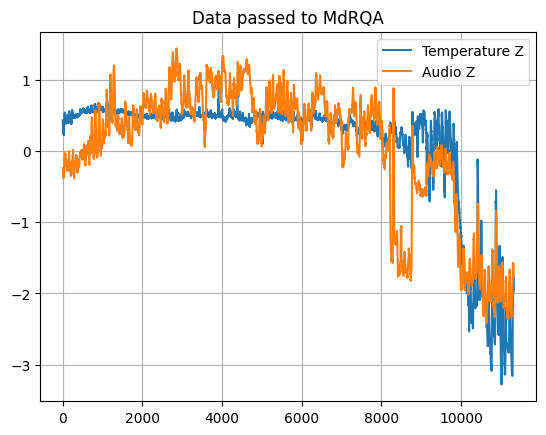

In [38]:
import matplotlib.pyplot as plt
plt.plot(data[:, 0], label='Temperature Z')
plt.plot(data[:, 1], label='Audio Z')
plt.legend()
plt.title("Data passed to MdRQA")
plt.grid(True)
plt.show()


In [39]:
print(df_final.columns)


Index(['temperature_z', 'humidity_z', 'audio_density_z', 'hive_power_z',
       'audio_smooth'],
      dtype='object')


In [40]:
# ✅ 确保从原始 dataframe 中提取 hive_power 和 temperature
df = pd.read_csv(file_path, parse_dates=["published_at"])
df = df[df["tag_number"] == 202204]
df = df.drop_duplicates(subset="published_at")
df = df.set_index("published_at")

# ✅ 重新选择包括 hive_power 在内的列
df = df[["temperature", "hive_power"]]

# ✅ 15分钟重采样
df_resampled = df.resample("15min").mean()

# ✅ 标准化 temperature（如果之前已做，可跳过）
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_resampled[['temperature']]),
    columns=["temperature_z"],
    index=df_resampled.index
)

# ✅ 标准化 hive_power 并合并成最终分析表
df_scaled["hive_power_z"] = StandardScaler().fit_transform(df_resampled[["hive_power"]])
df_final = df_scaled.dropna()


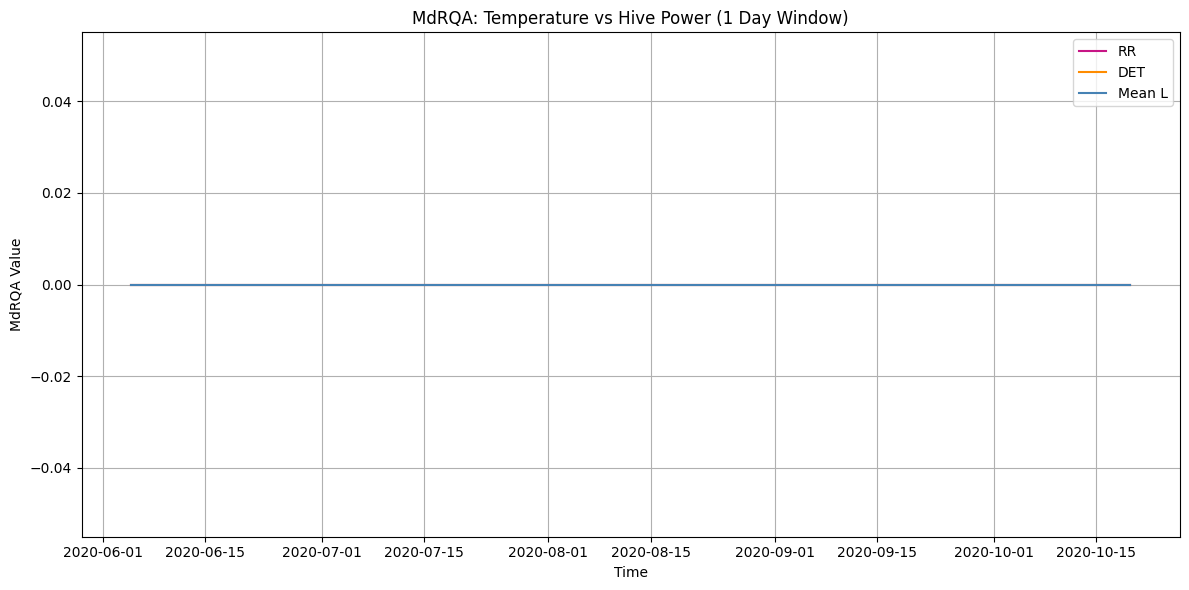

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiSyncPy import synchrony_metrics as sm
from sklearn.preprocessing import StandardScaler


# ✅ 提取时间序列并清理缺失值（确保两列都有值）
ts_temperature = df_final[['temperature_z']].copy()
ts_hivepower = df_final[['hive_power_z']].copy()
df_clean = pd.concat([ts_temperature, ts_hivepower], axis=1).dropna()

# ✅ 拆成独立时间序列
ts_temperature = df_clean['temperature_z']
ts_hivepower = df_clean['hive_power_z']

# ✅ 准备数据窗口
df_mdrqa_ready = df_clean[['temperature_z', 'hive_power_z']]

# ✅ 设置参数
window_length = 96    # 一天（15分钟 × 96 = 24小时）
window_step = 48      # 每12小时滑动一次
radius = 1.5          # hive_power 噪音较大，半径设宽一点
columns = ['temperature_z', 'hive_power_z']

# ✅ 执行 MdRQA 分析
results = []
for start in range(0, len(df_mdrqa_ready) - window_length + 1, window_step):
    end = start + window_length
    segment = df_mdrqa_ready[columns].iloc[start:end].dropna().values
    if len(segment) < window_length:
        continue
    recmat = sm.recurrence_matrix(segment, radius=radius)
    rr, det, l_mean, l_max = sm.rqa_metrics(recmat)
    center_time = df_mdrqa_ready.index[start + window_length // 2]
    results.append({
        'time': center_time,
        'RR': rr,
        'DET': det,
        'L': l_mean,
        'L_max': l_max
    })

# ✅ 转为 DataFrame 并画图
results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))
plt.plot(results_df['time'], results_df['RR'], label='RR', color='mediumvioletred')
plt.plot(results_df['time'], results_df['DET'], label='DET', color='darkorange')
plt.plot(results_df['time'], results_df['L'], label='Mean L', color='steelblue')
plt.xlabel("Time")
plt.ylabel("MdRQA Value")
plt.title("MdRQA: Temperature vs Hive Power (1 Day Window)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
df_final[['temperature_z', 'audio_density_z']].dropna().describe()


KeyError: "['audio_density_z'] not in index"

In [ ]:
df_resampled[['temperature', 'audio_density']].dropna().describe()
df_scaled[['temperature_z', 'audio_density_z']].describe()
